In [1]:
# Setup the environment for google colab
try:
    from google.colab import output
    output.enable_custom_widget_manager()
    !pip install ipympl jiminy_py[meshcat] > /dev/null 2>&1
    !wget https://raw.githubusercontent.com/duburcqa/jiminy/demo/flexible_arm.urdf > /dev/null 2>&1
except ImportError:
    pass

In [2]:
# Enable matplotlib interactive notebook integration
%matplotlib widget

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import jiminy_py.core as jiminy  # The main module of jiminy - this is what gives access to the Robot
from jiminy_py.simulator import Simulator

In [4]:
# Reduce the waiting time before refreshing the viewer after closing for convenience
import jiminy_py.viewer.meshcat.server
jiminy_py.viewer.meshcat.server.WAIT_COM_TIMEOUT = 2.0

# Flexible arm

## Instantiate a robot

In [5]:
# First mount the drive
urdf_path = 'flexible_arm.urdf'
robot = jiminy.Robot()
robot.initialize(urdf_path, has_freeflyer=False)

# Add motor
motor_joint_name = 'base_to_link1'
motor = jiminy.SimpleMotor(motor_joint_name)
robot.attach_motor(motor)
motor.initialize(motor_joint_name)

# Add sensor
encoder = jiminy.EncoderSensor('active_joint')
robot.attach_sensor(encoder)
encoder.initialize('base_to_link1')

In [6]:
# We set inertia along non-moving axis to 1.0 for numerical stability
k_j, d_j = 100.0, 5.0
model_options = robot.get_model_options()
model_options['dynamics']['flexibilityConfig'] = [{
    'frameName': f"link{i}_to_link{i+1}",
    'stiffness': k_j * np.ones(3),
    'damping': d_j * np.ones(3),
    'inertia': np.array([1.0, 1.0, 0.0])
} for i in range(1,5)]
model_options['joints']['enablePositionLimit'] = False
model_options['joints']['enableVelocityLimit'] = False
robot.set_model_options(model_options)

## Instantiate a controller

In [7]:
# Define the command: for now, the motor is off and doesn't modify the output torque.
Kp, Kd = 150.0, 5.0
q_ref = np.pi/4
def compute_command(t, q, v, sensors_data, command):
    q_a, v_a = sensors_data['EncoderSensor']
    command[:] = Kp * (q_ref - q_a) - Kd * v_a

In [8]:
# Instantiate and bind the controller to the robot
robot.controller = jiminy.FunctionalController(compute_command)

## Instantiate a simulator

In [9]:
# Create a simulator using this robot and controller
simulator = Simulator(robot)

In [10]:
# Configure the integrator
engine_options = simulator.engine.get_options()
engine_options['stepper']['controllerUpdatePeriod'] = 0.001
engine_options['stepper']['odeSolver'] = 'runge_kutta_4'
engine_options['stepper']['dtMax'] = 0.000125
simulator.engine.set_options(engine_options)

# Make log files standalone for replay/post-processing on any machine
engine_options["telemetry"]["isPersistent"] = True

In [11]:
# print out all the available engine options
engine_options

{'contacts': {'stabilizationFreq': 20.0,
  'transitionVelocity': 0.01,
  'transitionEps': 0.001,
  'damping': 2000.0,
  'torsion': 0.0,
  'friction': 1.0,
  'stiffness': 1000000.0,
  'model': 'constraint'},
 'world': {'groundProfile': <jiminy_py.core.HeightmapFunction at 0x2f223bbc0>,
  'gravity': array([ 0.  ,  0.  , -9.81,  0.  ,  0.  ,  0.  ])},
 'joints': {'boundDamping': 10000.0, 'boundStiffness': 10000000.0},
 'constraints': {'successiveSolveFailedMax': 100,
  'regularization': 0.001,
  'solver': 'PGS'},
 'telemetry': {'enableEnergy': True,
  'enableMotorEffort': True,
  'enableCommand': True,
  'enableForceExternal': False,
  'enableVelocity': True,
  'enableAcceleration': True,
  'enableConfiguration': True,
  'isPersistent': True},
 'stepper': {'controllerUpdatePeriod': 0.001,
  'sensorsUpdatePeriod': 0.0,
  'timeout': 0.0,
  'successiveIterFailedMax': 1000,
  'dtRestoreThresholdRel': 0.2,
  'odeSolver': 'runge_kutta_4',
  'iterMax': 0,
  'tolRel': 0.0001,
  'dtMax': 0.000125,

## Simulate the system

In [12]:
# Set initial condition and simulation length
q_rigid_init, v_rigid_init = np.array([0.]), np.array([0.])
duration = 2.0

# Launch the simulation
simulator.simulate(duration, q_rigid_init, v_rigid_init, is_state_theoretical=True)

  0%|          | 0.00/2.0 [00:00<?]

In [13]:
# Replay the result
camera_pose = ([0.0, -1.4, 2.0e-5], [np.pi/2, 0.0, 0.0])
simulator.replay(camera_pose=camera_pose, speed_ratio=0.5, backend="panda3d-sync")

Rendering frames: 100%|██████████| 120/120 [00:00<00:00, 210.37it/s]


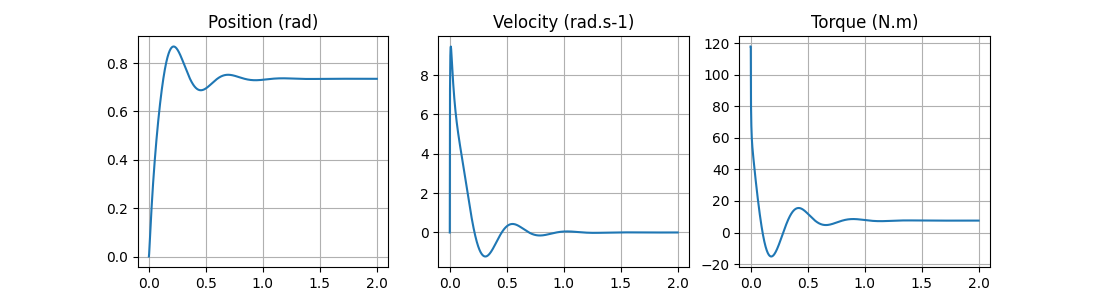

In [14]:
# Get dictionary of logged scalar variables
log_vars = simulator.log_data["variables"]

# Display the true position, velocity and effort of the actuated joint.
# The effort includes the internal dynamics if any (friction, plus custom if any).
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11, 3))
ax1.plot(log_vars['Global.Time'], log_vars[f'HighLevelController.currentPosition{motor_joint_name}'])
ax1.grid()
ax1.set_title('Position (rad)')
ax2.plot(log_vars['Global.Time'], log_vars[f'HighLevelController.currentVelocity{motor_joint_name}'])
ax2.grid()
ax2.set_title('Velocity (rad.s-1)')
ax3.plot(log_vars['Global.Time'], log_vars[f'HighLevelController.currentEffort{motor_joint_name}'])
ax3.grid()
ax3.set_title('Torque (N.m)')
plt.show();

In [15]:
# Extract the deformation angles along rotation axis
q_flex = []
for fj_name, fj_idx in zip(robot.flexible_joint_names, robot.flexible_joint_indices):
    quat = (log_vars[f'HighLevelController.currentPosition{fj_name}QuatX'],
            log_vars[f'HighLevelController.currentPosition{fj_name}QuatY'],
            log_vars[f'HighLevelController.currentPosition{fj_name}QuatZ'],
            log_vars[f'HighLevelController.currentPosition{fj_name}QuatW'])
    idx_q = robot.pinocchio_model.joints[fj_idx].idx_q
    cos_yaw = - 1.0 + 2.0 * (quat[3] ** 2 + quat[0] ** 2)
    sin_yaw = 2.0 * (quat[2] * quat[3] + quat[0] * quat[1])
    q_flex.append(np.arctan2(sin_yaw, cos_yaw))
q_flex = np.stack(q_flex, axis=0)

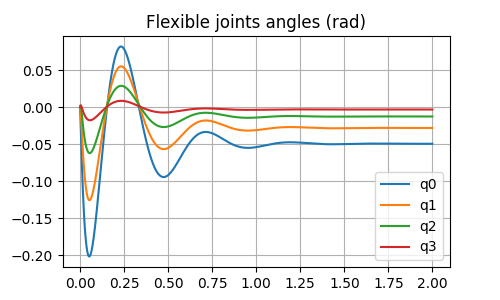

In [16]:
# Display the deformation angles
plt.figure(figsize=(5, 3))
for k, q_i in enumerate(q_flex):
    plt.plot(log_vars['Global.Time'], q_i, label=f'q{k}')
plt.grid()
plt.legend()
plt.title('Flexible joints angles (rad)')
plt.show();

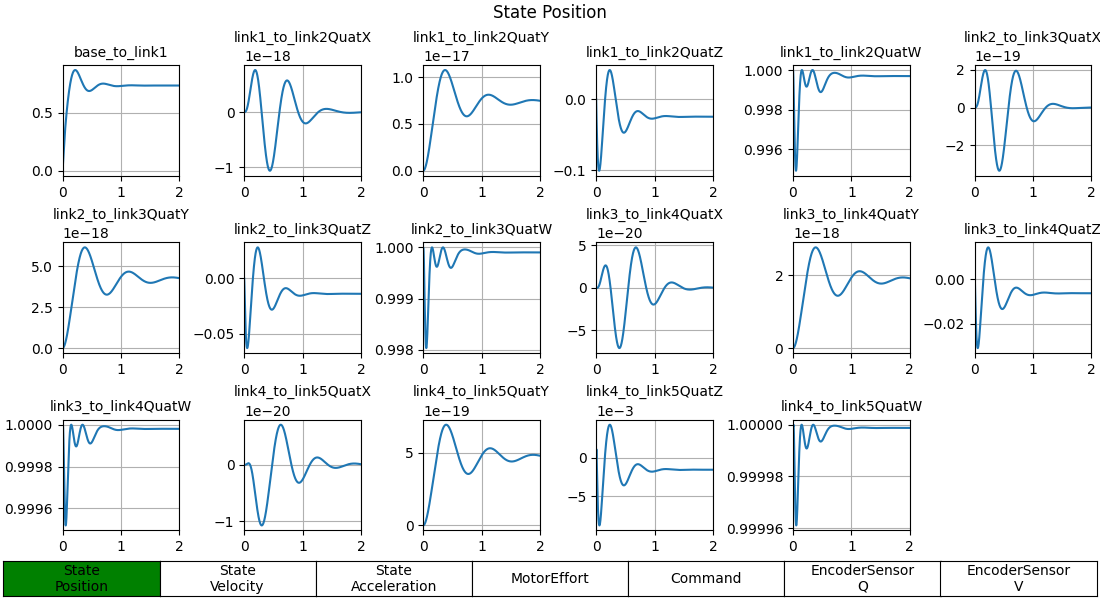

In [17]:
tabbed_fig = simulator.plot(enable_flexiblity_data=True)
tabbed_fig.figure.set_size_inches(11, 6)